In [1]:
# load some packages
from matplotlib.text import Text
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from ripser import ripser
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import oat_python as oat

/Users/floyd/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# load the data
dfzoo = pd.read_csv(
        'https://www.dropbox.com/scl/fi/a1t16rtialcw03n50ffkc/concepts_Zoology_608.csv.gz?rlkey=vjv60sfbhofbgvzfzdkrlurl1&st=ciu77f72&dl=1',
        compression='gzip',
    )
dfmath = pd.read_csv(
        'https://www.dropbox.com/scl/fi/cxm0t30xbugvc0ju6btie/concepts_Pure-Mathematics_101.csv.gz?rlkey=8270ulgto48prpxiqihldk7fb&st=a6lcxijj&dl=1',
        compression='gzip',
    )
dfapplymath = pd.read_csv(
        'https://www.dropbox.com/scl/fi/06fc7tb0m7eh8t01oqxyo/concepts_Applied-Mathematics_102.csv.gz?rlkey=h23rkf2rtrhzxmqcjpfsezcc5&st=3z1zcqix&dl=1',
        compression='gzip',
    )
dfphymath = pd.read_csv(
        'https://www.dropbox.com/scl/fi/62eki84qj8cynzgpa4a77/concepts_Mathematical-Physics_105.csv.gz?rlkey=uyppmch667rgl63vzh6tqxbxb&st=5o7q6nr0&dl=1',
        compression='gzip',
    )
dfphysics = pd.read_csv(
        'https://www.dropbox.com/scl/fi/wghriw9wj0w3ojieueio4/concepts_Classical-Physics_203.csv.gz?rlkey=8xdl1rww9y30ln85jmme50k4l&st=laz7gha5&dl=1',
        compression='gzip',
    )
dfmatterphy = pd.read_csv(
        'https://www.dropbox.com/scl/fi/gfj1ybt919b42kbv86nn7/concepts_Condensed-Matter-Physics_204.csv.gz?rlkey=71p0kws3n6dt0r74rk7otupyf&st=dfoqrbsk&dl=1',
        compression='gzip',
    )
dfgeophy = pd.read_csv(
        'https://www.dropbox.com/scl/fi/hlg296rmmf8shjsaw243j/concepts_Geophysics_404.csv.gz?rlkey=8e39m0n4lnuvak57l7euv5scl&st=7im8wged&dl=1',
        compression='gzip',
    )
dfoptphy = pd.read_csv(
        'https://www.dropbox.com/scl/fi/shhr0frn3unn7y6s3t5tm/concepts_Optical-Physics_205.csv.gz?rlkey=455lnzpiuer7zr0ubgg7f4rm6&st=qjbdfqsw&dl=1',
        compression='gzip',
    )
dfquaphy = pd.read_csv(
    'https://www.dropbox.com/scl/fi/cdm93w3ru1r5yogexobmo/concepts_Quantum-Physics_206.csv.gz?rlkey=fop7qe6celar2dh9t5nr6x8pg&st=4wwj25kw&dl=1',
    compression='gzip',
)


In [3]:
# config
MIN_RELEVANCE = 0.7
MIN_YEAR = 1920
MAX_YEAR = 2021  # when the data is from
MIN_CONCEPT_FREQ = 0.0001
MAX_CONCEPT_FREQ = 0.001
max_dim = 3

def dataprocess(df):
    df = df[df['relevance_mean'] >= MIN_RELEVANCE]
    df = df[df['year'] >= MIN_YEAR]
    num_articles = df['article_id'].nunique()
    concept_freq = df.groupby('concept').transform('size') / num_articles
    df = df[(concept_freq >= MIN_CONCEPT_FREQ) & (concept_freq <= MAX_CONCEPT_FREQ)]
    df = df[['article_id', 'concept', 'year']]

    return(df)

In [4]:
def conceptprocess(df):
    concepts = (
            df
                .sort_values('year')  # sort so earliest year is first
                .groupby('concept')
                .agg(
                    year=('year', 'min'),
                    count=('article_id', 'nunique')
                )
                .reset_index()
        )

    # normalize the year
    concepts['norm_year'] = (concepts['year'] - MIN_YEAR) / (MAX_YEAR - MIN_YEAR)
    concepts['inv_count'] = 1 / concepts['count']
    return(concepts)

In [5]:
def edgeprocess(df):
    edges = df.merge(df, on=['article_id', 'year'], suffixes=['_source', '_target'])
    edges = edges[edges['concept_source'] < edges['concept_target']]  # remove self links (u - u) and the second occurance (u - v vs v - u)
    # edges = edges.sort_values('year').drop_duplicates(subset=['concept_source', 'concept_target']).reset_index(drop=True)
    edges = edges.groupby(['concept_source', 'concept_target']).agg(
            year=('year', 'min'),
            count=('article_id', 'nunique')
        ).reset_index()

    edges['norm_year'] = (edges['year'] - MIN_YEAR) / (MAX_YEAR - MIN_YEAR)
    edges['inv_count'] = 1 / edges['count']
    return(edges)

In [6]:
def graphprocess(concepts,edges):
    G = nx.Graph()

    # add the nodes
    G.add_nodes_from([(c, {'norm_year': ny, 'inv_count': ic}) for c, ny, ic in zip(concepts['concept'], concepts['norm_year'], concepts['inv_count'])])

    # add the edges
    G.add_edges_from([(u, v, {'norm_year': ny, 'inv_count': ic}) for u, v, ny, ic in zip(edges['concept_source'], edges['concept_target'], edges['norm_year'], edges['inv_count'])])
    
    return(G)

In [7]:
def runcrocker(G):
    adj_year = nx.adjacency_matrix(G, weight='norm_year')
    adj_year.setdiag([d['norm_year'] for _, d in G.nodes(data=True)])
    adj_inv_count = nx.adjacency_matrix(G, weight='inv_count')
    adj_inv_count.setdiag([d['inv_count'] for _, d in G.nodes(data=True)])
    adj_inv_count = adj_inv_count.sorted_indices()

    # run crocker
    years = np.unique(adj_year.data)
    inv_counts = np.unique(adj_inv_count.data)
    betti_curves = np.empty((len(years), len(inv_counts), max_dim + 1))

    for i, y in enumerate(years):
        # zero out things not included
        y_adj = adj_inv_count.copy()
        y_adj[adj_year > y] = 0
        y_adj.eliminate_zeros()

        # calcaulte homology
        factored = oat.rust.FactoredBoundaryMatrixVr(y_adj, max_dim)
        homology = factored.homology(False, False)

        # create betti curve
        for d in range(max_dim + 1):
            dim_homology = homology[homology['dimension'] == d]  # get teh right dimensional features
            betti_curves[i, :, d] = ((dim_homology['birth'].values <= inv_counts[:, None]) &
                                    (dim_homology['death'].values > inv_counts[:, None])).sum(axis=1)
    X, Y = np.meshgrid(years, inv_counts)
    fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
    for dim in range(4):
        row, col = divmod(dim, 2)
        ax = axs[row][col]

        Z = betti_curves[:, :, dim].T
        Z = np.nan_to_num(Z, nan=0.0, posinf=0.0, neginf=0.0)

        if np.all(Z == Z[0, 0]):
            print(f"dim={dim} skipped: constant Z")
            continue
        cp = ax.contour(X, Y, Z, levels=[1, 5, 10, 20, 50, 100, 200, 300, 500, 800, 1300, 2000, 3000],
                        colors='black', linewidths=0.8)
        ax.clabel(cp, inline=True, fontsize=8)
        ax.set_xlabel("Normalized Year")
        ax.set_title(f"$\\beta_{dim}$")
    axs[0][0].set_ylabel("Inv_count")
    axs[1][0].set_ylabel("Inv_count")
    plt.tight_layout()
    plt.show()

In [8]:
def mainfunc(df):
    df = dataprocess(df)
    concepts = conceptprocess(df)
    edges = edgeprocess(df)
    G = graphprocess(concepts,edges)
    runcrocker(G)

zoology


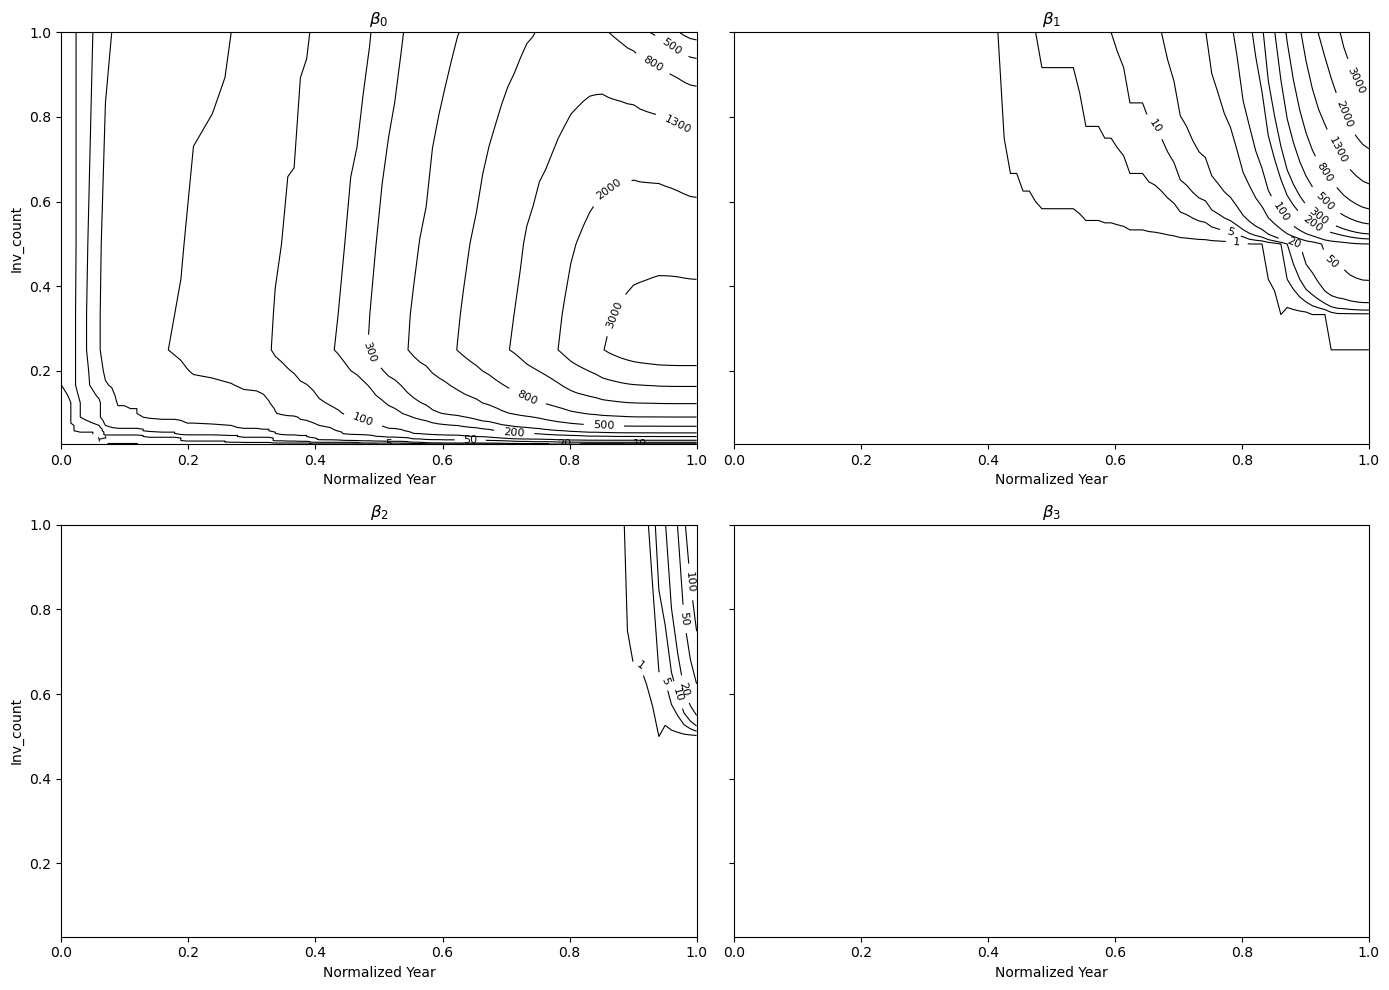

pure math


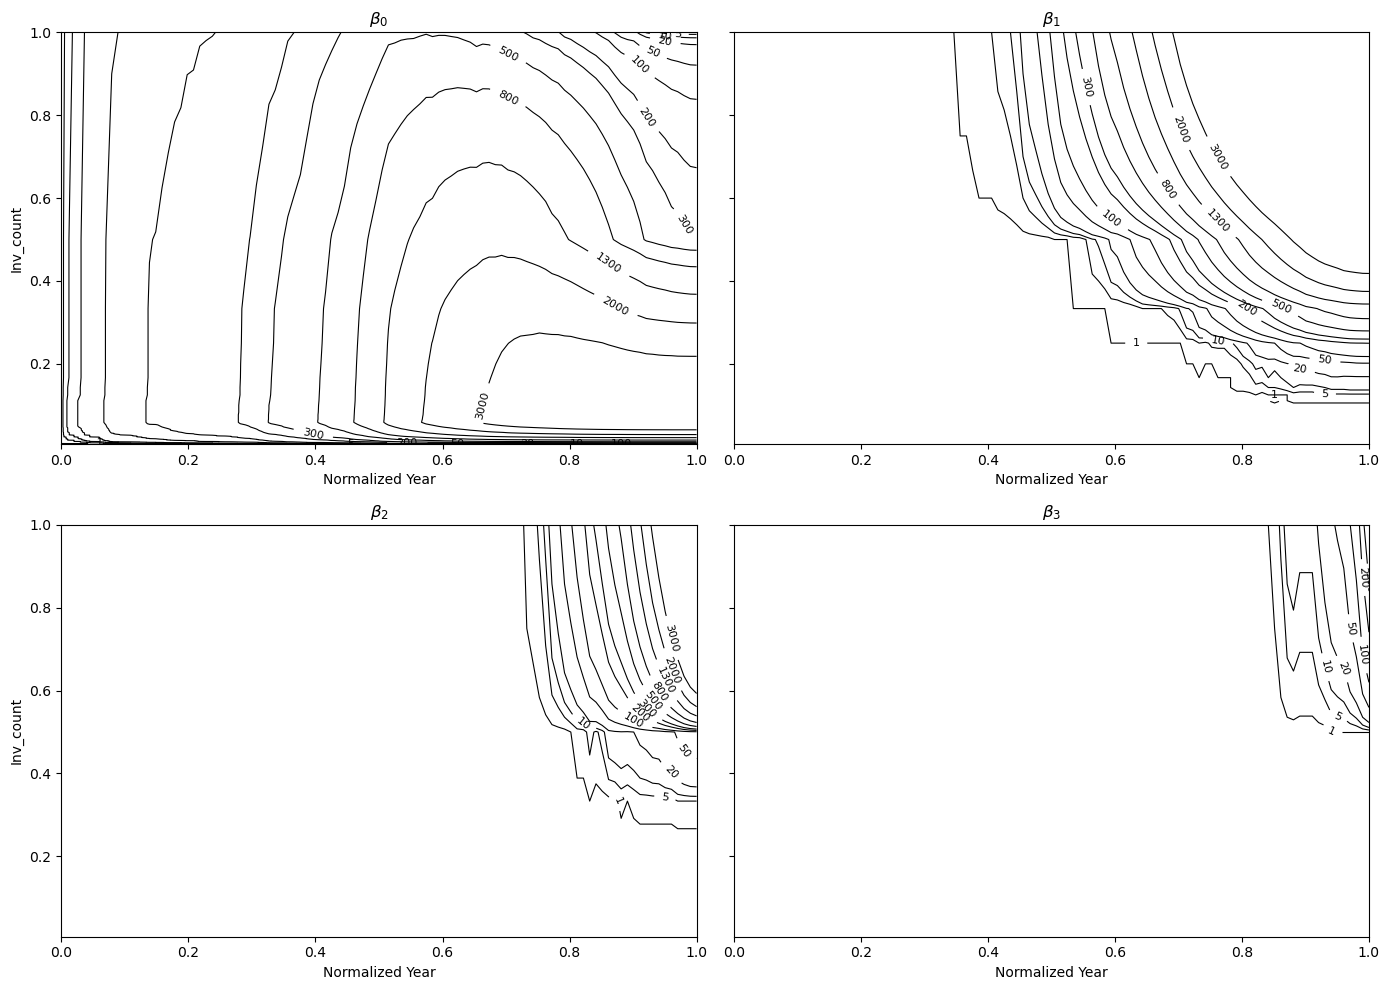

physics math
dim=2 skipped: constant Z
dim=3 skipped: constant Z


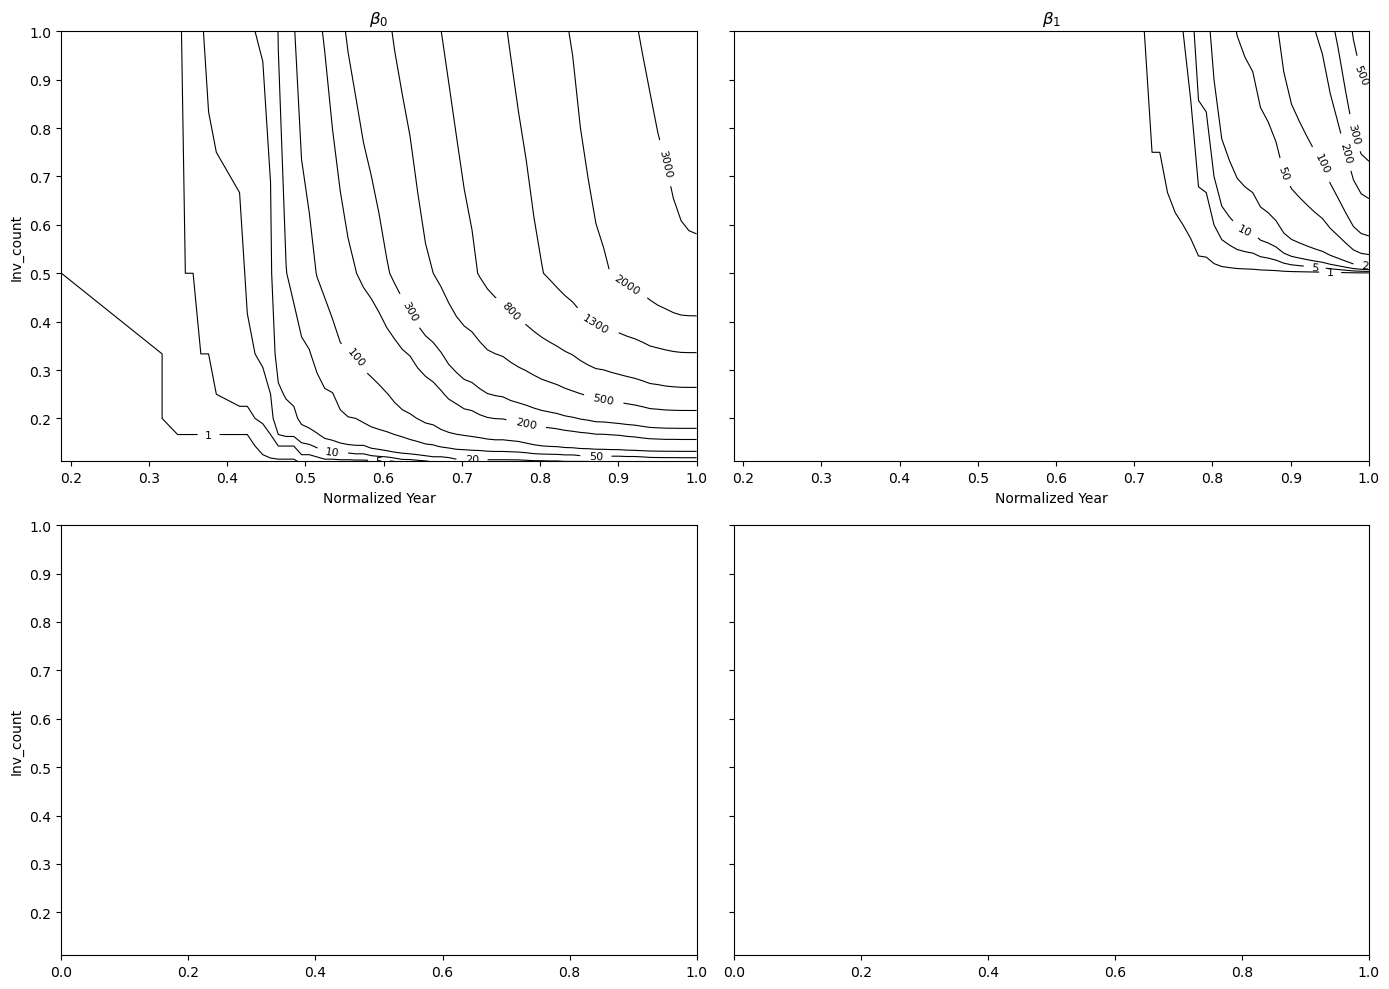

apply math


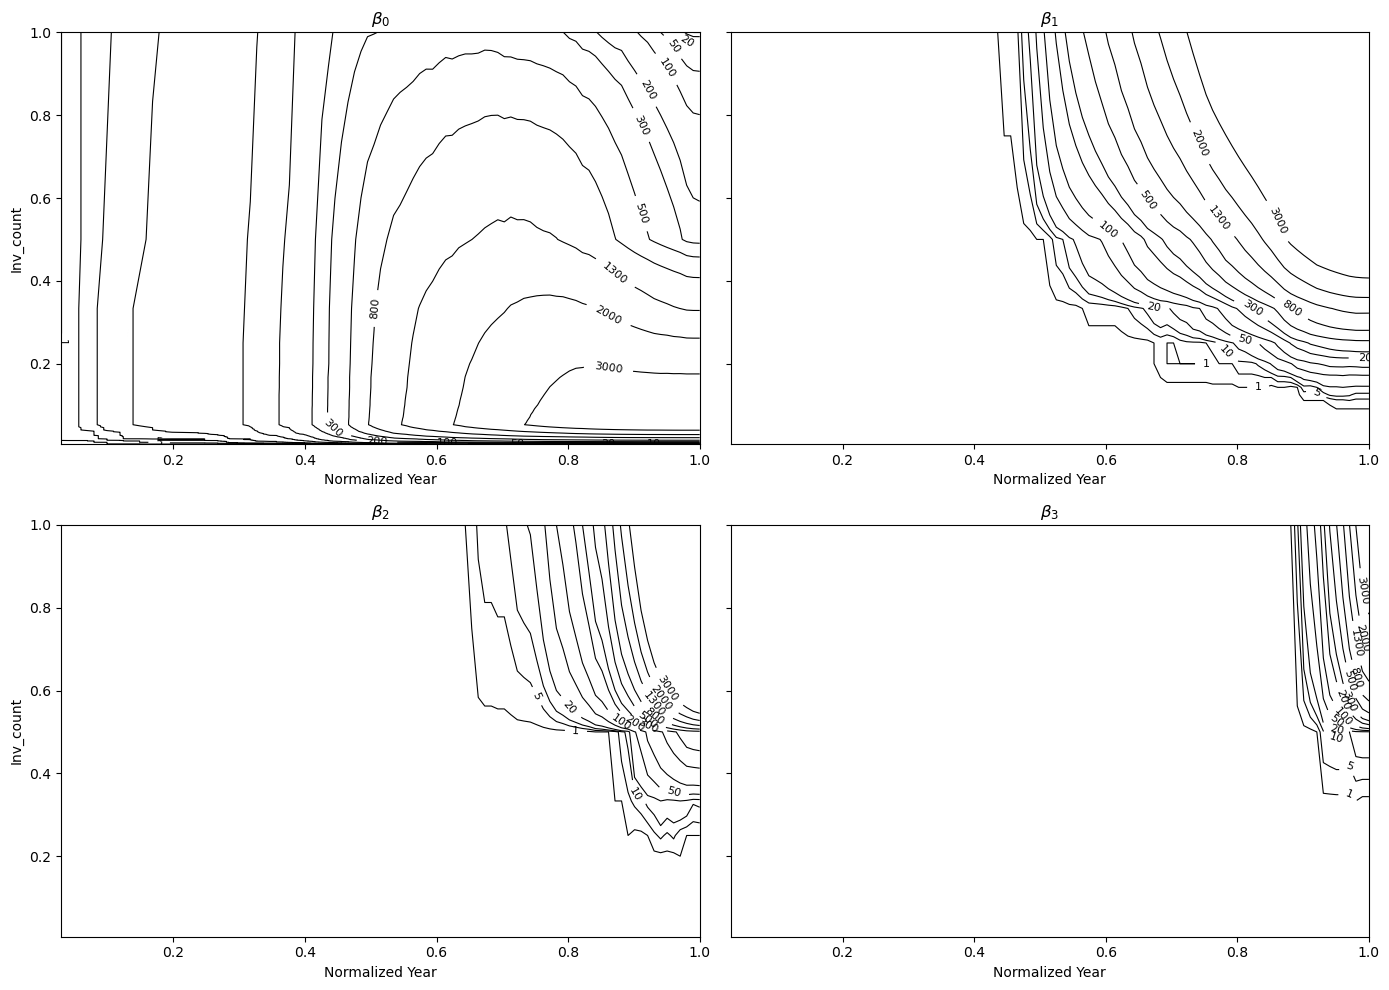

classic physics
dim=3 skipped: constant Z


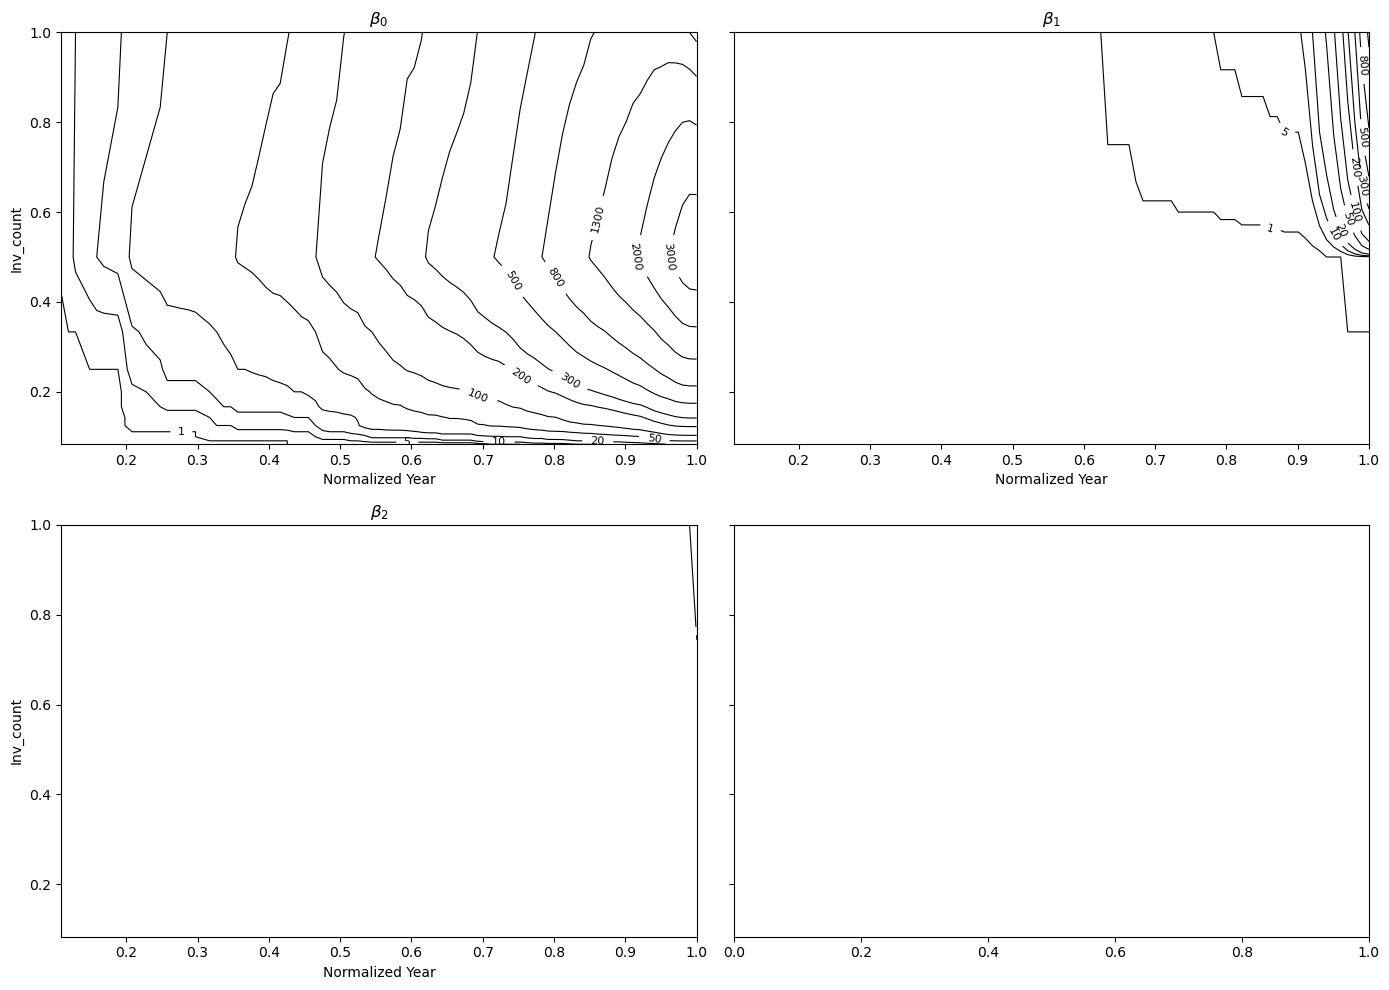

matter physics


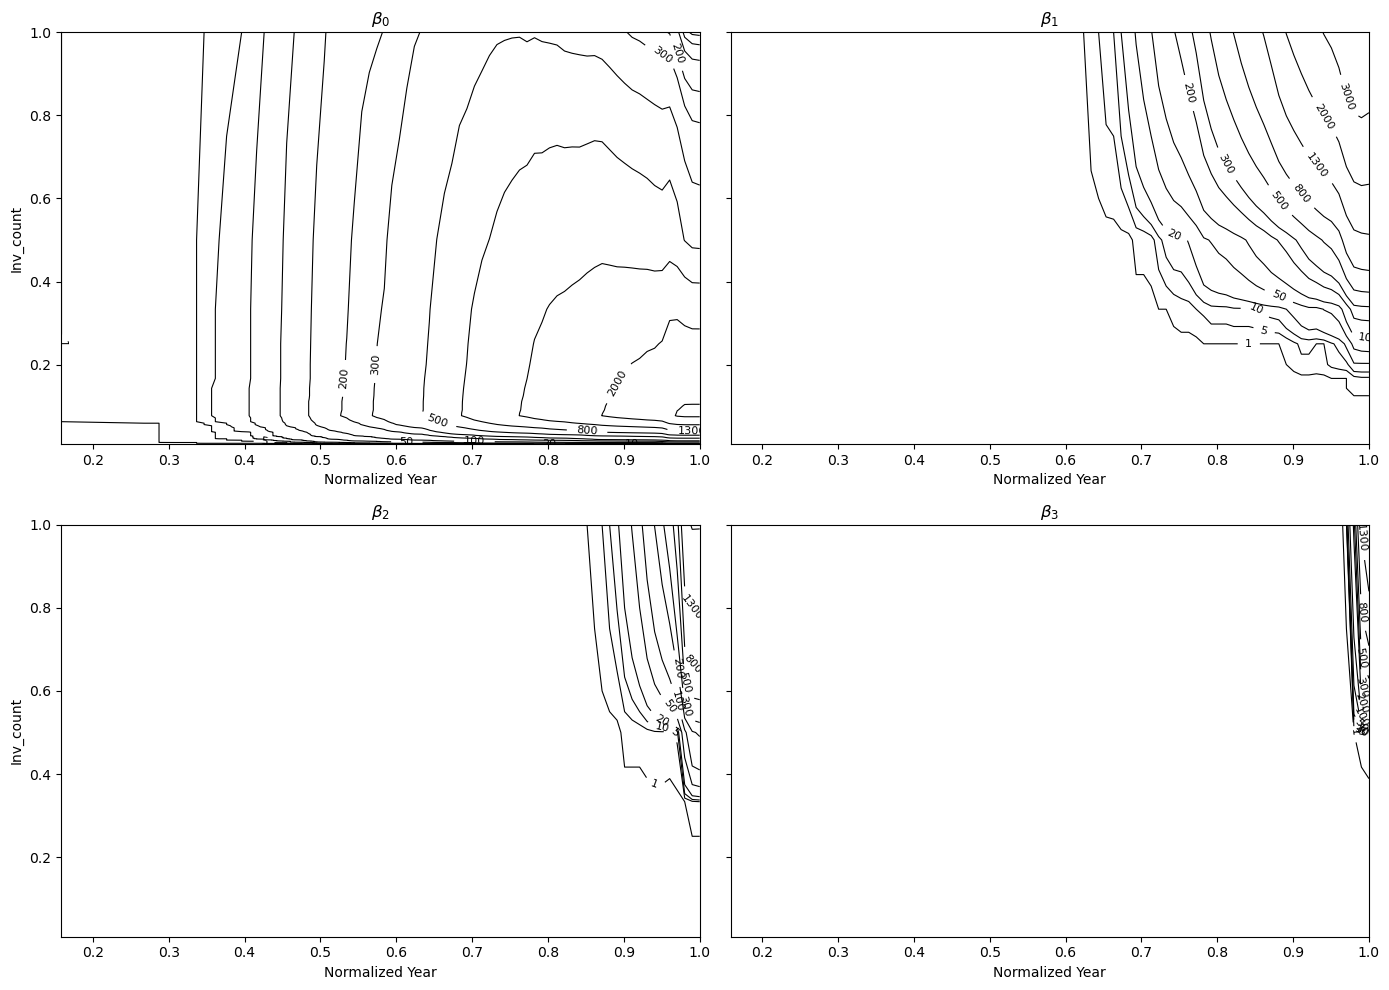

geophysics


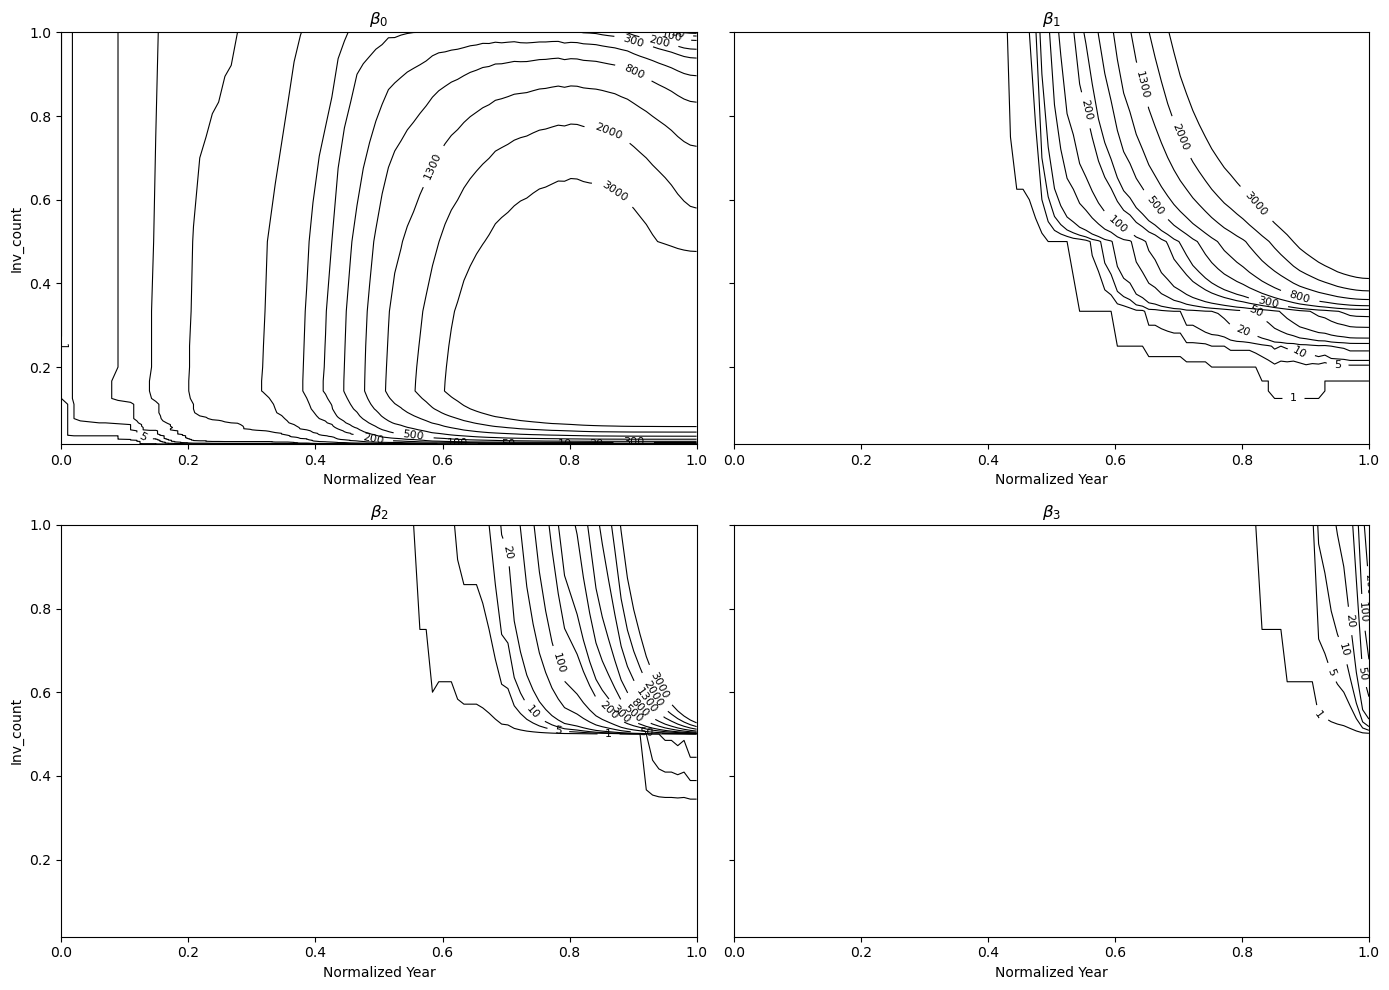

optimal physics


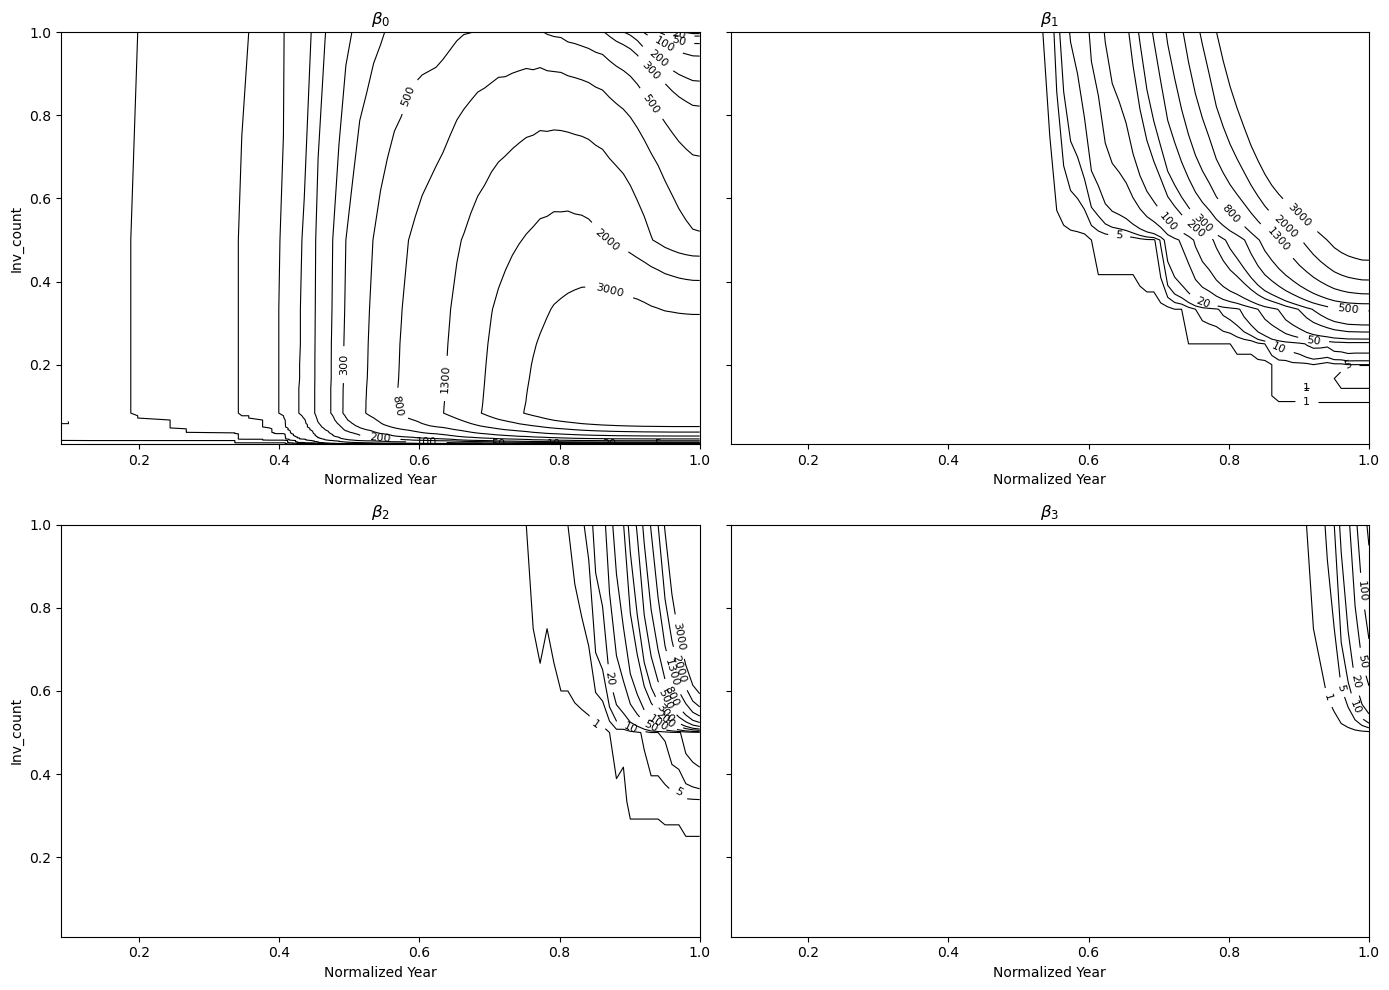

quantum physics


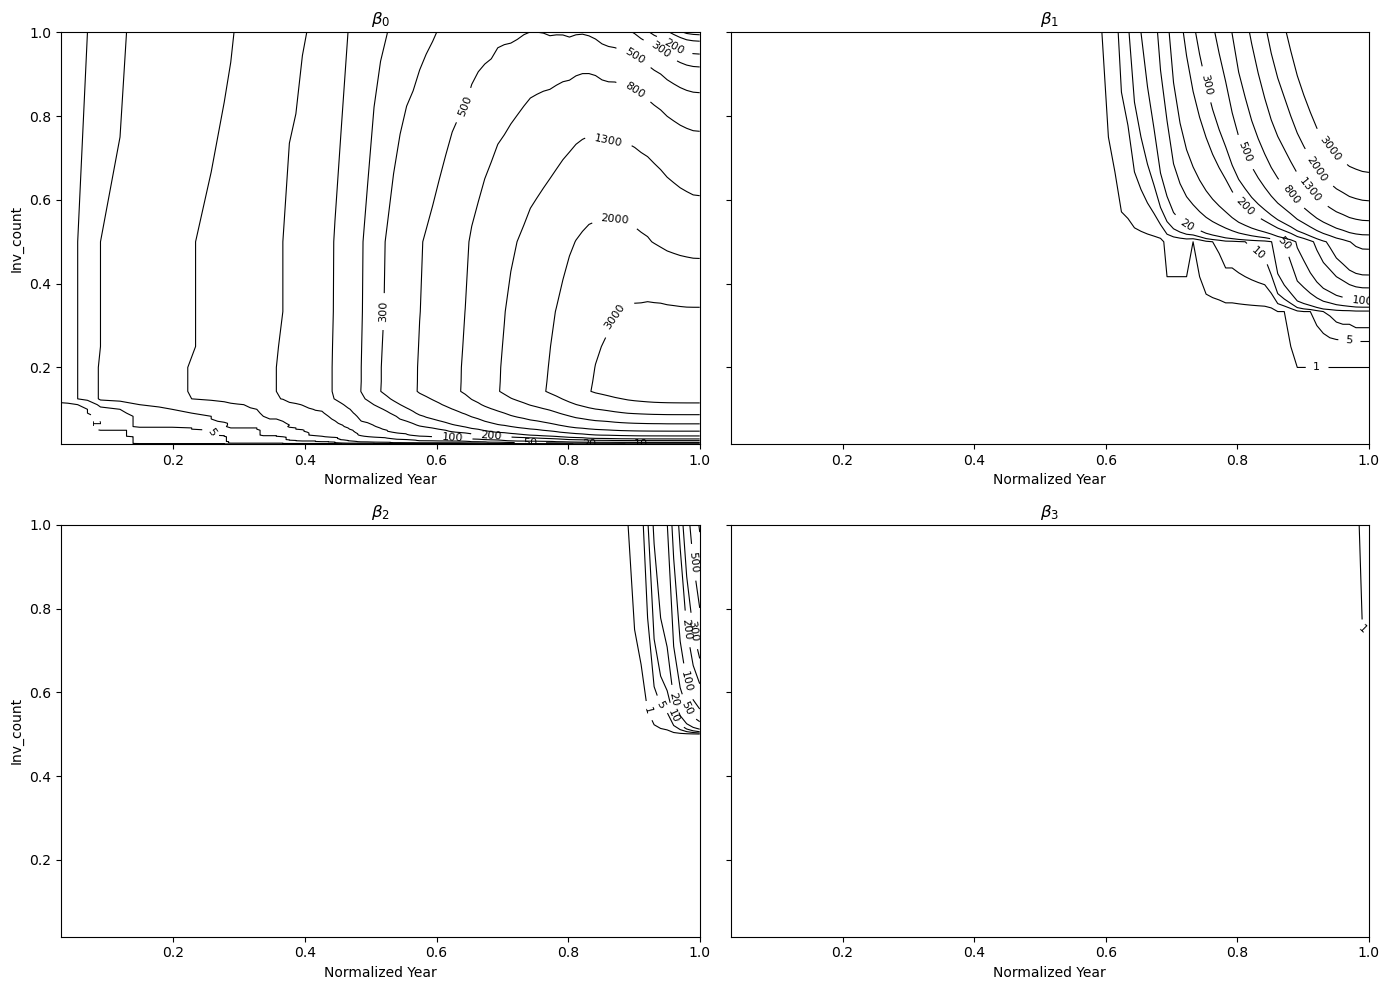

In [9]:
print('zoology')
mainfunc(dfzoo)
print('pure math')
mainfunc(dfmath)
print('physics math')
mainfunc(dfphymath)
print('apply math')
mainfunc(dfapplymath)
print('classic physics')
mainfunc(dfphysics)
print('matter physics')
mainfunc(dfmatterphy)
print('geophysics')
mainfunc(dfgeophy)
print('optimal physics')
mainfunc(dfoptphy)
print('quantum physics')
mainfunc(dfquaphy)

In [10]:
#point meaning: at inv_count(ep), at year(t), the number of holes
#